In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import datetime
import seaborn as sns
import pingouin as pg

from palettable.colorbrewer.sequential import YlGnBu_8
from palettable.colorbrewer.sequential import YlGn_9

# my functions
from funcs import fold, get_filelist, read_sims
from funcs_fig import maps, bars

#### Read in simulation output

In [5]:
# read in maizsim output
#files = []
#for i in np.arange(1961, 1971): # simulations to year 1970 so far
#    filelist = get_filelist('/home/disk/eos8/ach315/upscale/sims/opt_drysoil/' + str(i))
#    files.extend(filelist[:])

In [6]:
#df_sims, df_issues = read_sims(files)
#df_sims.to_csv('/home/disk/eos8/ach315/upscale/data/sims_6170_dsoil.csv')

In [3]:
df_sims = pd.read_csv('/home/disk/eos8/ach315/upscale/data/sims_6170_dsoil.csv', 
                     dtype={'site':'str'}, index_col=0)

#### Read in site info

In [4]:
# read in site info
df_sites_all = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/site_summary.csv', 
                           index_col=0, dtype={'site': str})

# filter based on planting area & irrigation
df_sites = df_sites_all[(df_sites_all.area > 1000) & (df_sites_all.perct_irri < 50)]
df_sites.head()

,site,class,station,state,tzone,lat,lon,years,area,perct_irri
5,722060,1,JACKSONVILLE INTL ARPT,FL,-5,30.500,-81.700,27,4978.0,10.089223
6,722070,1,SAVANNAH INTL AP,GA,-5,32.117,-81.200,22,8108.6,6.585904
7,722080,1,CHARLESTON INTL ARPT,SC,-5,32.900,-80.033,25,41559.4,5.152189
8,722110,1,TAMPA INTERNATIONAL AP,FL,-5,27.967,-82.533,8,50807.8,31.561666
9,722140,1,TALLAHASSEE REGIONAL AP [ISIS],FL,-5,30.400,-84.350,19,24496.7,13.348148


#### Read in weather info

In [5]:
df_wea = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/wea_summary.csv', dtype={'site': 'str'}, index_col=0)
df_wea.reset_index(inplace=True, drop=True)
df_wea.head()

,site,year,temp,rh,precip,solrad,vpd
0,722060,1961,23.875626,73.319667,711.7,224.052621,0.804103
1,722060,1962,24.837383,71.376170,844.3,231.331182,0.915040
2,722060,1964,24.184194,75.293234,1050.7,217.245110,0.758866
3,722060,1965,24.555986,73.515469,937.3,223.575509,0.832212
4,722060,1966,23.630849,76.711442,1158.9,213.357394,0.691391


#### Read in parameter info

In [6]:
df_params = pd.read_csv('/home/disk/eos8/ach315/upscale/inits/param_100.csv')
df_params = df_params.drop(['rmax_ltar'], axis=1)

param_range = {'juv_leaves': [15, 25],
               'stayGreen': [3,8],
               'rmax_ltir': [0.5, 1.5],
               'phyllo': [2, 4],
               'LM_min': [80, 120],
               'Vcmax': [60, 80],
               'Vpmax': [60, 120],
               'g1': [1, 10], 
               'ref_potential': [-4, -1]}

params = df_params.columns
df_params_fold = pd.DataFrame(columns=params)
for i in params: 
    df_params_fold[i] = fold(df_params[i], param_range[i][0], param_range[i][1])

df_params['cvar'] = list(df_params.index)
df_params_fold['cvar'] = list(df_params.index)
df_params_fold.head()

,juv_leaves,stayGreen,rmax_ltir,phyllo,LM_min,Vcmax,Vpmax,g1,ref_potential,cvar
0,0.8,0.288,0.74,0.655,0.46925,0.8645,0.542833,0.984444,0.206667,0
1,0.1,0.826,0.05,0.990,0.24625,0.3550,0.463500,0.041111,0.390000,1
2,0.6,0.702,0.50,0.520,0.03100,0.3325,0.359333,0.320000,0.456667,2
3,0.9,0.334,0.18,0.620,0.44250,0.4780,0.161167,0.428889,0.123333,3
4,0.5,0.264,0.32,0.565,0.87700,0.2220,0.687833,0.590000,0.200000,4


#### Merge datasets

In [7]:
df_sims_params = pd.merge(df_sims, df_params, on='cvar')
df_sims_params_sites = pd.merge(df_sims_params, df_sites, on='site')
df_all = pd.merge(df_sims_params_sites, df_wea, on=['site','year'])
df_all.head()

,year,cvar,site,date,jday,time,leaves,mature_lvs,drop_lvs,LA,...,lat,lon,years,area,perct_irri,temp,rh,precip,solrad,vpd
0,1961,0,722060,07/18/1961,22480,7,23.00,23,19,317.38,...,30.5,-81.7,27,4978.0,10.089223,23.875626,73.319667,711.7,224.052621,0.804103
1,1961,1,722060,08/14/1961,22507,20,16.00,16,14,149.40,...,30.5,-81.7,27,4978.0,10.089223,23.875626,73.319667,711.7,224.052621,0.804103
2,1961,2,722060,07/30/1961,22492,15,21.00,21,18,197.59,...,30.5,-81.7,27,4978.0,10.089223,23.875626,73.319667,711.7,224.052621,0.804103
3,1961,3,722060,08/02/1961,22495,16,25.00,25,20,324.35,...,30.5,-81.7,27,4978.0,10.089223,23.875626,73.319667,711.7,224.052621,0.804103
4,1961,4,722060,04/23/1961,22394,20,4.97,4,1,137.18,...,30.5,-81.7,27,4978.0,10.089223,23.875626,73.319667,711.7,224.052621,0.804103


#### group simulation outputs

In [8]:
df_sims_sitemean = df_all.groupby(['site']).mean()
df_sims_cvarmean = df_all.groupby(['cvar']).mean()

## Visualization

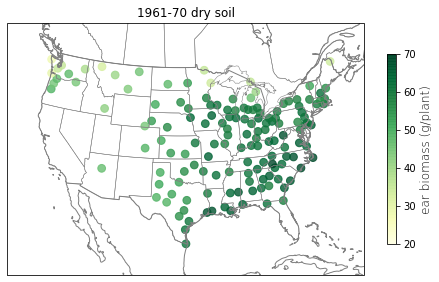

In [9]:
sites = df_sites[df_sites.site.isin(df_sims_sitemean.index)]
maps(sites, df_sims_sitemean, cbar_lab='ear biomass (g/plant)',
     title='1961-70 dry soil')

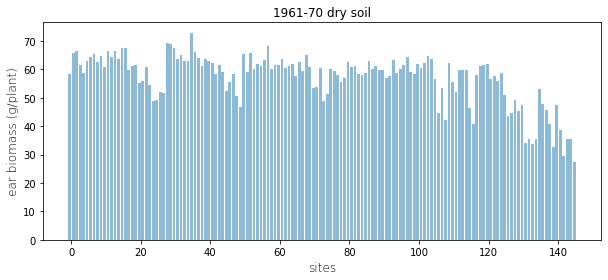

In [17]:
data = df_sims_sitemean.dm_ear
bars(data, xlab='sites', ylab='ear biomass (g/plant)', title='1961-70 dry soil')

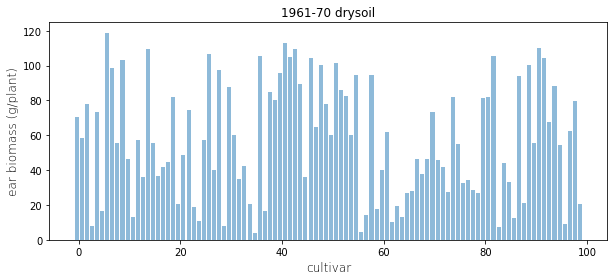

In [18]:
data = df_sims_cvarmean.dm_ear
bars(data, xlab='cultivar', ylab='ear biomass (g/plant)', title='1961-70 drysoil')

Text(0, 0.5, 'yield')

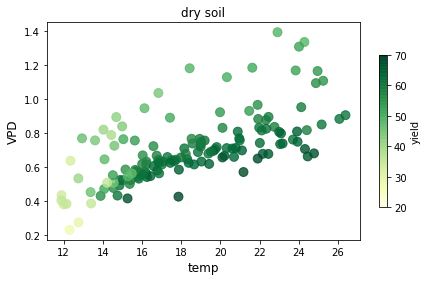

In [19]:
fig, ax = plt.subplots(figsize=(7,4))
sc = ax.scatter(df_sims_sitemean.temp, df_sims_sitemean.vpd, 
                c=df_sims_sitemean.dm_ear, cmap=YlGn_9.mpl_colormap, alpha=0.8, s=80,
                vmin=20, vmax=70)
ax.set_xlabel('temp', size=12)
ax.set_ylabel('VPD', size=12)
ax.set_title('dry soil')
cbar = fig.colorbar(sc, shrink=0.7)
cbar.ax.set_ylabel('yield')

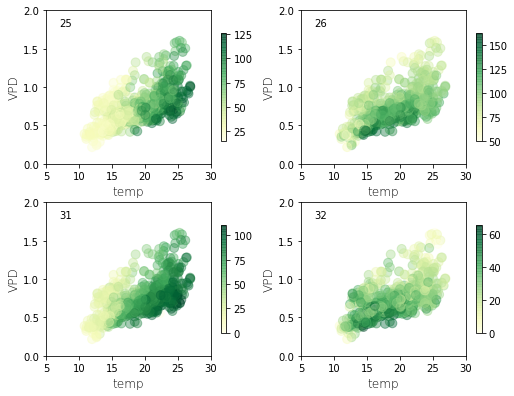

In [163]:
fig, axs = plt.subplots(2,2,figsize=(8,6))
cvars = [25,26,31,32]

for ax, cvar in zip(axs.flatten(), cvars):
    df_sims_cv = df_all[df_all.cvar==cvar]
    sc = ax.scatter(df_sims_cv.temp, df_sims_cv.vpd, 
                    c=df_sims_cv.dm_ear, cmap=YlGn_9.mpl_colormap, alpha=0.4, s=80)
    ax.set_xlabel('temp', size=12, weight='light')
    ax.set_ylabel('VPD', size=12, weight='light')
    ax.text(7,1.8, cvar)
    ax.set_xlim(5,30)
    ax.set_ylim(0,2)
    cbar = fig.colorbar(sc, ax=ax, shrink=0.7)
fig.subplots_adjust(left=0.15, bottom=0.15, right=0.95, top=0.95, wspace=0.24, hspace=0.25)
#plt.savefig('/home/disk/eos8/ach315/upscale/figs/cspace_yield.png', format='png', dpi=800)

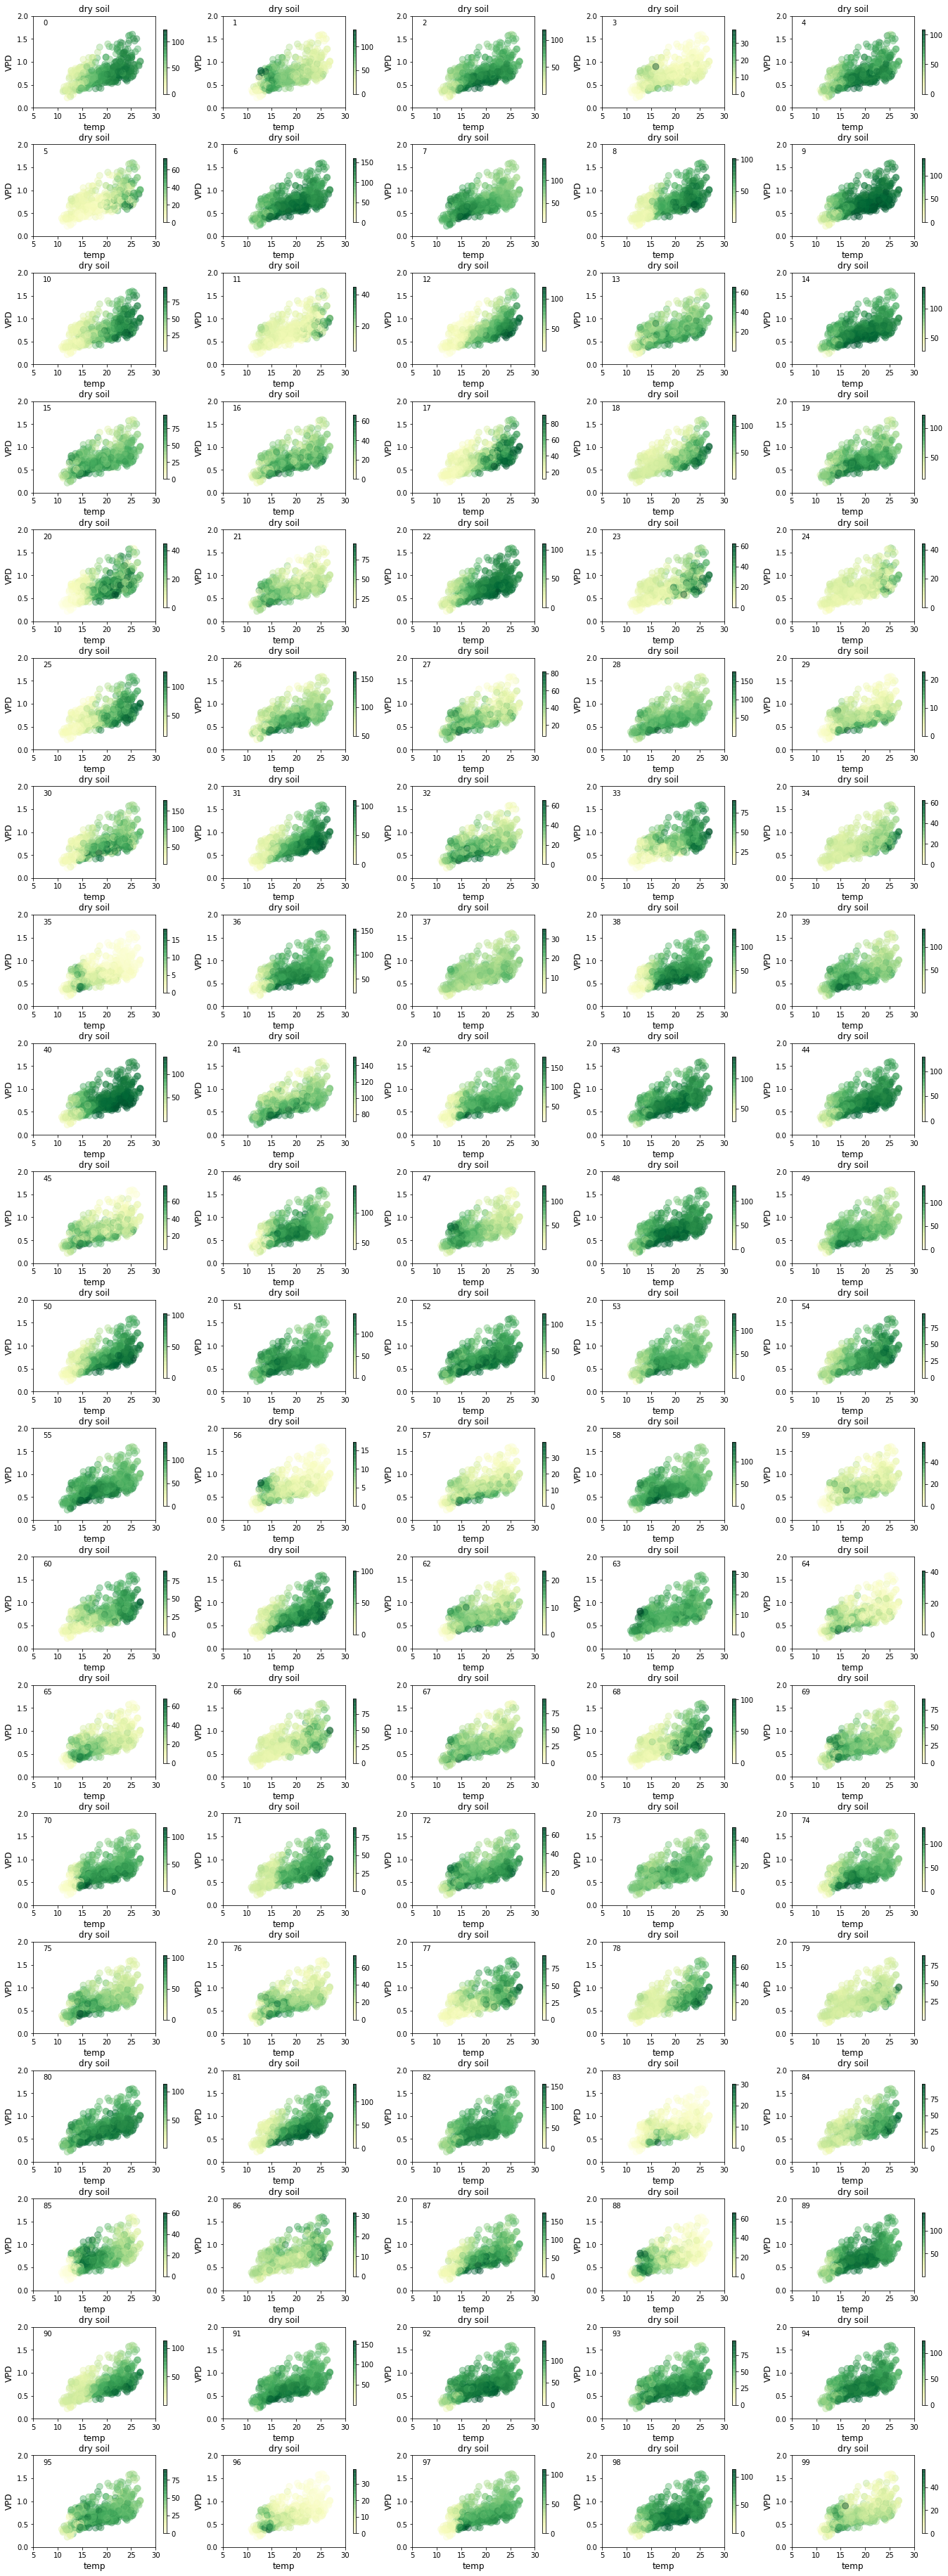

In [10]:
fig, axs = plt.subplots(20, 5, figsize=(20, 50))
cvars = np.arange(100)

for ax, cvar in zip(axs.flatten(), cvars):
    df_sims_cv = df_all[df_all.cvar==cvar]
    sc = ax.scatter(df_sims_cv.temp, df_sims_cv.vpd, 
                    c=df_sims_cv.dm_ear, cmap=YlGn_9.mpl_colormap, alpha=0.4, s=80)
    ax.set_xlabel('temp', size=12)
    ax.set_xlim(5,30)
    ax.set_ylim(0,2)
    ax.set_ylabel('VPD', size=12)
    ax.text(7,1.8, cvar)
    ax.set_title('dry soil')
#    ax.set(title='cultivar ' + str(cvar))
    cbar = fig.colorbar(sc, ax=ax, shrink=0.7)
fig.subplots_adjust(left=0.05, bottom=0, right=0.95, top=1, wspace=0.24, hspace=0.4)

### 201106 Next taks for this graph:
Add in past observations of yield into this graph as color

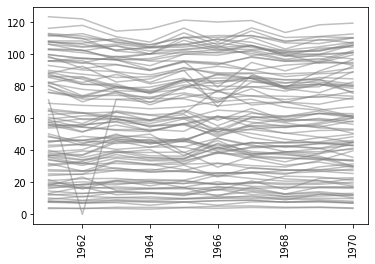

In [13]:
for i in np.arange(100):
    plt.plot(df_sims[df_sims.cvar==i].groupby('year').mean().dm_ear, 
             color='grey', alpha=0.5)
    plt.xticks(rotation=90)

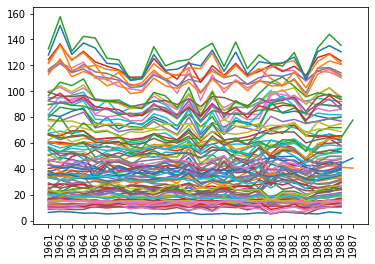

In [29]:
for i in np.arange(100):
    plt.plot(df_sims[df_sims.cvar==i].groupby('year').mean().dm_ear)
    plt.xticks(rotation=90)

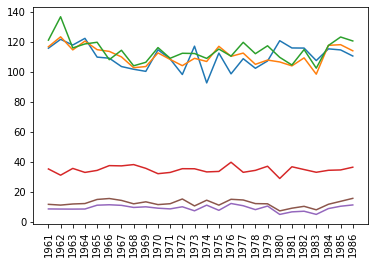

In [32]:
cvar_list = [6,7,41,32,35,96]

for i in cvar_list:
    plt.plot(df_sims[df_sims.cvar==i].groupby('year').mean().dm_ear)
    plt.xticks(rotation=90)

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

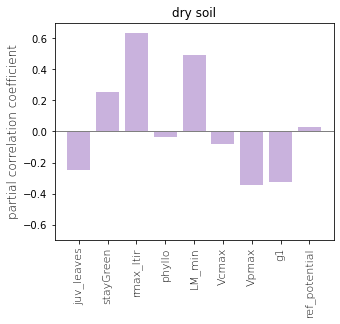

In [23]:
# setting up parameter values and ear biomass
df_stats = pd.concat([df_params.iloc[:,:-1], # remove 'cvar' column
                      df_sims_cvarmean.dm_ear], # including mean ear biomass for each cultivar
                     axis=1) 

# calculate partial correlation coefficient
from partial_corr import partial_corr
output = partial_corr(df_stats)
params = list(df_params.columns[:-1]) # remove 'cvar' column
corrs = output[-1][:-1] # select final row in correlation matrix - correlation with ear biomass,
                        # and remove final correlation coefficient,
                        # which is the correlation coefficient with ear biomass itself = 1

# figure 
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(1,1,1)
ax.bar(params, corrs, alpha=0.5, color='tab:purple')
ax.set_ylabel('partial correlation coefficient', fontsize=12, weight='light')
ax.set_title('dry soil')
ax.set_ylim(-0.7,0.7)
ax.axhline(0, color='grey', lw=1)
plt.xticks(rotation=90, fontsize=11, weight='light')

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

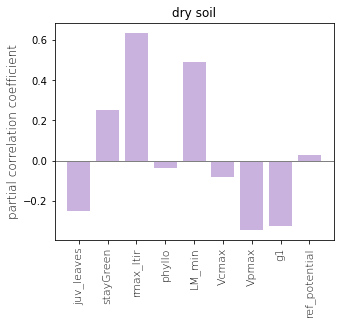

In [71]:
# setting up parameter values and ear biomass
df_stats = pd.concat([df_params.iloc[:,:-1], # remove 'cvar' column
                      df_sims_cvarmean.dm_ear], # including mean ear biomass for each cultivar
                     axis=1) 

# calculate partial correlation coefficient
from partial_corr import partial_corr
output = partial_corr(df_stats)
params = list(df_params.columns[:-1]) # remove 'cvar' column
corrs = output[-1][:-1] # select final row in correlation matrix - correlation with ear biomass,
                        # and remove final correlation coefficient,
                        # which is the correlation coefficient with ear biomass itself = 1

# figure 
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(1,1,1)
ax.bar(params, corrs, alpha=0.5, color='tab:purple')
ax.set_ylabel('partial correlation coefficient', fontsize=12, weight='light')
ax.set_title('dry soil')
ax.axhline(0, color='grey', lw=1)
plt.xticks(rotation=90, fontsize=11, weight='light')

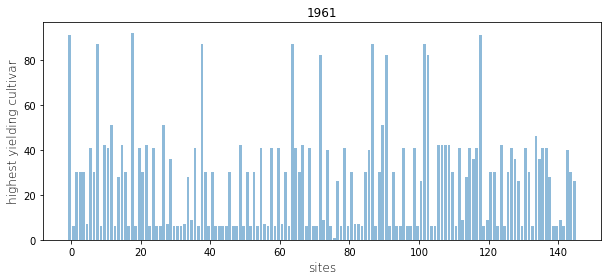

In [72]:
ears = []
cvars_high = []
sites = list(set(df_all.site))

for i in sites:
    df_site = df_all[df_all.site == i]
    ear = df_site.dm_ear.max()
    cvar = float(df_site[df_site.dm_ear == ear].cvar)
    ears.append(ear)
    cvars_high.append(cvar)

bars(cvars_high, xlab='sites', ylab='highest yielding cultivar', title='1961')

In [81]:
list(df_site[df_site.dm_ear == ear].cvar)

[29, 31]

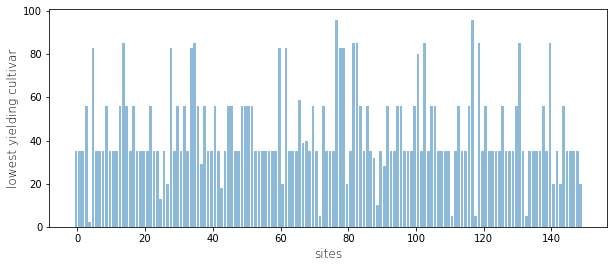

In [84]:
ears = []
cvars_low = []
sites = list(set(df_all.site))

for i in sites:
    df_site = df_all[df_all.site == i]
    df_site = df_site[df_site.dm_ear != 0]
    ear = df_site.dm_ear.min()
    cvar = list(df_site[df_site.dm_ear == ear].cvar)
    ears.append(ear)
    cvars_low.extend(cvar)

bars(cvars_low, xlab='sites', ylab='lowest yielding cultivar', title='')

Text(0.09, 0.5, 'ear biomass (g/plant)')

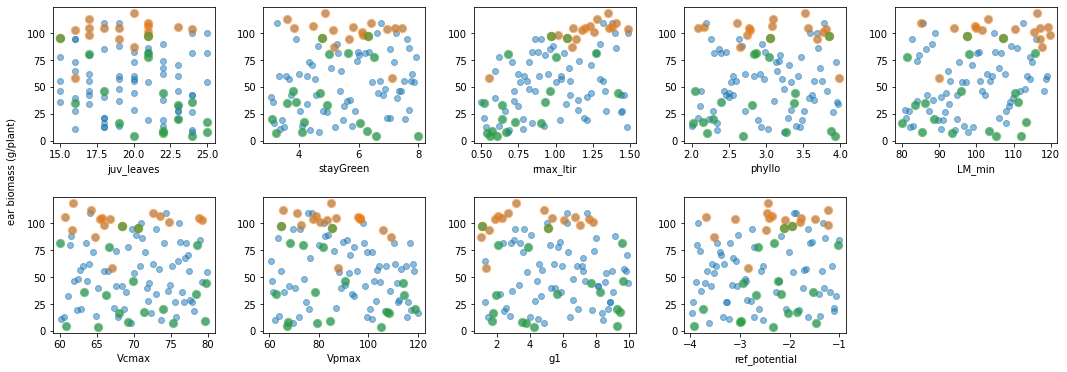

In [94]:
#!!! this output looks weird will need to think about it

fig = plt.figure(figsize=(18,6))

for i in np.arange(1,10): 
    ax = fig.add_subplot(2,5,i)
    ax.scatter(df_params.iloc[:,i-1], df_sims_cvarmean.dm_ear, alpha=0.5)
    ax.set_xlabel(df_params.columns[i-1])
    
    ax.scatter(df_params.iloc[hyield_vars,i-1], df_sims_cvarmean.iloc[hyield_vars].dm_ear, s=70, alpha=0.5)
    ax.scatter(df_params.iloc[lyield_vars,i-1], df_sims_cvarmean.iloc[lyield_vars].dm_ear, s=70, alpha=0.5)

    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)
fig.text(0.09, 0.5, 'ear biomass (g/plant)', va='center', rotation='vertical')

In [91]:
from statistics import mean, stdev

xpos = []
means_hyield = []
error_hyield = []
means_lyield = []
error_lyield = []

hyield_vars = list(set(cvars_high))
lyield_vars = list(set(cvars_low))

for counter,param in enumerate(params):
    xpos.append(counter)
    m = mean(fold(list(df_params.iloc[hyield_vars,:][param]), param_range[param][0], param_range[param][1]))
    e = stdev(fold(list(df_params.iloc[hyield_vars,:][param]), param_range[param][0], param_range[param][1]))
    n = len(fold(list(df_params.iloc[hyield_vars,:][param]), param_range[param][0], param_range[param][1]))
    means_hyield.append(m)
    error_hyield.append(e/np.sqrt(n))

for counter,param in enumerate(params):
    m = mean(fold(list(df_params.iloc[lyield_vars,:][param]), param_range[param][0], param_range[param][1]))
    e = stdev(fold(list(df_params.iloc[lyield_vars,:][param]), param_range[param][0], param_range[param][1]))
    n = len(fold(list(df_params.iloc[lyield_vars,:][param]), param_range[param][0], param_range[param][1]))
    means_lyield.append(m)
    error_lyield.append(e/np.sqrt(n))
    

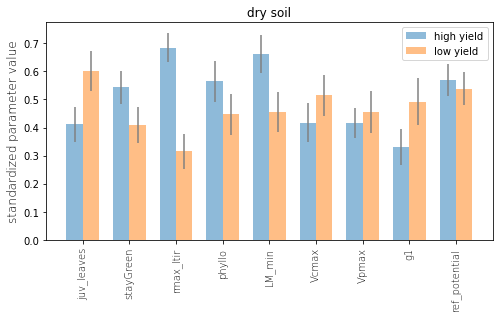

In [93]:
fig, ax = plt.subplots(figsize=(8,4))
w = 0.35
bars1 = ax.bar([x - w/2 for x in xpos], means_hyield, yerr=error_hyield, width=w, 
               align='center', alpha=0.5, ecolor='grey', capsize=0, label='high yield')
bars2 = ax.bar([x + w/2 for x in xpos], means_lyield, yerr=error_lyield, width=w, 
               align='center', alpha=0.5, ecolor='grey', capsize=0, label='low yield')
ax.set_xticks(xpos)
ax.set_xticklabels(params, rotation=90, weight='light')
ax.set_ylabel('standardized parameter value', size=12, weight='light')
ax.set_title('dry soil')
ax.legend()

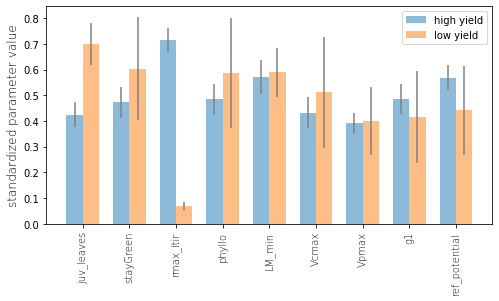

In [123]:
fig, ax = plt.subplots(figsize=(8,4))
w = 0.35
bars1 = ax.bar([x - w/2 for x in xpos], means_hyield, yerr=error_hyield, width=w, 
               align='center', alpha=0.5, ecolor='grey', capsize=0, label='high yield')
bars2 = ax.bar([x + w/2 for x in xpos], means_lyield, yerr=error_lyield, width=w, 
               align='center', alpha=0.5, ecolor='grey', capsize=0, label='low yield')
ax.set_xticks(xpos)
ax.set_xticklabels(params, rotation=90, weight='light')
ax.set_ylabel('standardized parameter value', size=12, weight='light')
ax.legend()

### Try this figure for differnet climate space? ^

In [168]:
df_sims_merged

,year,cvar,site,date,jday,time,leaves,mature_lvs,drop_lvs,LA,...,Vcmax,Vpmax,g1,ref_potential,class,station,state,tzone,lat,lon
0,1961,0.0,722060,07/19/1961,22481,2,23.00,23,18,302.09,...,77.29,92.57,9.86,-3.38,1,JACKSONVILLE INTL ARPT,FL,-5,30.50,-81.70
1,1962,0.0,722060,07/12/1962,22839,17,24.00,24,19,299.23,...,77.29,92.57,9.86,-3.38,1,JACKSONVILLE INTL ARPT,FL,-5,30.50,-81.70
2,1964,0.0,722060,07/14/1964,23572,8,24.00,24,18,295.64,...,77.29,92.57,9.86,-3.38,1,JACKSONVILLE INTL ARPT,FL,-5,30.50,-81.70
3,1965,0.0,722060,07/16/1965,23939,13,23.00,23,18,291.11,...,77.29,92.57,9.86,-3.38,1,JACKSONVILLE INTL ARPT,FL,-5,30.50,-81.70
4,1966,0.0,722060,07/20/1966,24308,17,23.00,23,18,293.05,...,77.29,92.57,9.86,-3.38,1,JACKSONVILLE INTL ARPT,FL,-5,30.50,-81.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206634,1983,95.0,726550,10/28/1983,30617,2,25.00,25,20,370.08,...,70.01,92.25,8.61,-3.52,1,ST CLOUD REGIONAL ARPT,MN,-6,45.55,-94.05
206635,1983,96.0,726550,11/01/1983,30621,2,22.00,22,19,331.71,...,79.57,84.49,1.70,-2.98,1,ST CLOUD REGIONAL ARPT,MN,-6,45.55,-94.05
206636,1983,97.0,726550,11/29/1983,30649,23,17.00,17,14,443.11,...,72.56,117.85,5.46,-3.33,1,ST CLOUD REGIONAL ARPT,MN,-6,45.55,-94.05
206637,1983,98.0,726550,09/30/1983,30589,10,17.00,17,14,151.76,...,61.38,80.06,5.22,-3.87,1,ST CLOUD REGIONAL ARPT,MN,-6,45.55,-94.05


Text(0.09, 0.5, 'ear biomass (g/plant)')

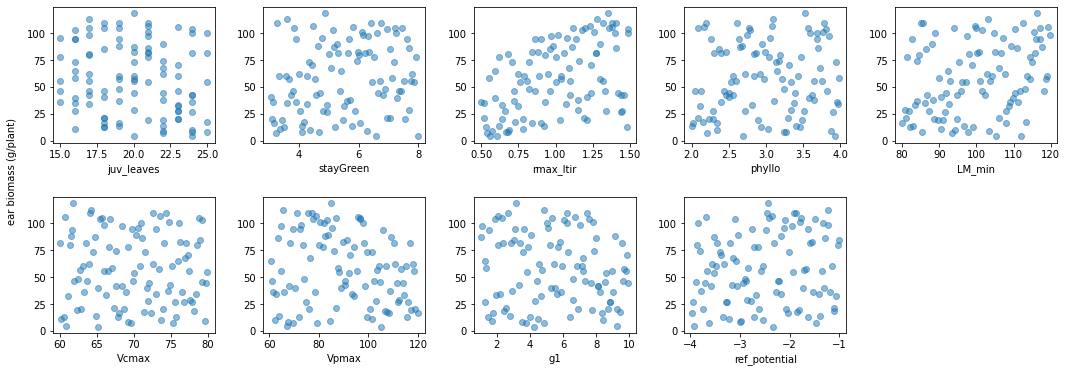

In [95]:
fig = plt.figure(figsize=(18,6))

for i in np.arange(1,10): 
    ax = fig.add_subplot(2,5,i)
    ax.scatter(df_params.iloc[:,i-1], df_sims_cvarmean.dm_ear, alpha=0.5)
    ax.set_xlabel(df_params.columns[i-1])
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)
fig.text(0.09, 0.5, 'ear biomass (g/plant)', va='center', rotation='vertical')

In [16]:
from funcs import get_filelist, read_sims

In [17]:
filelist = get_filelist('/home/disk/eos8/ach315/upscale/sims/opt/')

In [18]:
len(filelist)

315559